# Indirect TSQR


**Input**: Matrix $A \in \mathbb{R}^{m \times n}$ with $m \gg n$.  

The indirect TSQR method avoids explicitly assembling the final $Q$ matrix block-by-block. The idea is to first compute a stable global $R$ factor first, and then derives $Q$ implicitly from it.  

---

### 1) First step (local QR factorizations)  
- The matrix $A$ is divided into $p$ row blocks:  

$$
A = \begin{bmatrix} A_1^T & A_2^T & \cdots & A_p^T \end{bmatrix}^T,
\quad A_j \in \mathbb{R}^{m_j \times n}.
$$  

- Each block is used locally to factor the small R_j blocks:  

$$
A_j = Q_j^{(1)} R_j, 
\quad Q_j^{(1)} \in \mathbb{R}^{m_j \times n}, \; R_j \in \mathbb{R}^{n \times n}.
$$  

  
- The $Q_j^{(1)}$ matrices obtained are discarded and only the small $R_j$ are passed along.  



### 2) Second step (global QR reduction)  
- The local triangular matrices are stacked vertically:  

$$
R_{\text{stack}} = 
\begin{bmatrix} 
R_1 \\ R_2 \\ \vdots \\ R_p 
\end{bmatrix}
\in \mathbb{R}^{pn \times n}.
$$  

- To obtain the **final global $R$** it is necessary to perform a second QR factorization:  

$$
R_{\text{stack}} = \tilde{Q} \, R, 
\quad \tilde{Q} \in \mathbb{R}^{pn \times n}, \; R \in \mathbb{R}^{n \times n}.
$$  

- Unlike other methods, the $Q_j^{(1)}$ blocks are not explicitily multiplied with pieces of $\tilde{Q}$ to assemble the final $Q$, instead they are discarded.  



### 3) Recovering $Q$ indirectly  
- By construction, $A = Q R$.  
- Since $R$ is already available, $Q$ can be obtained as:  

$$
Q = A R^{-1}.
$$  

- This avoids explicitly combining the intermediate $Q_j^{(1)}$ and $\tilde{Q}$ matrices.  
- Instead, a final *map* step applies the small matrix $R^{-1}$ (size $n \times n$) to each row block of $A$, yielding the blocks of $Q$ on the fly.  

---

The optimization idea is that only  the small $R_j$ factors are passed between workers, never the large $Q_j^{(1)}$. The tradeoff is that it  requires access to the full $A$ again to compute $Q$, which may be costly for very large datasets, but avoids storing intermediate $Q_j$.
On the other hand the two-level QR decomposition ensures orthogonality and therefore an improved numerical stability.  
  


In [23]:
import dask.array as da
import dask
import numpy as np
import time
from scipy.linalg import solve_triangular 
from sklearn.datasets import fetch_california_housing


In [26]:
# CLUSTER DEPLOYMENT ON CLOUDVENETO
from dask.distributed import Client, SSHCluster

cluster = SSHCluster(
    ["10.67.22.154", "10.67.22.216", "10.67.22.116", "10.67.22.113"],
    connect_options={"known_hosts": None},
    remote_python="/home/ubuntu/miniconda3/bin/python",
    scheduler_options={"port": 8786, "dashboard_address": ":8797"},
    worker_options={
        "n_workers": 4,       # N. of processess per VM. CloudVeneto's large VM offers 4-core CPU, but for now we only spawn 1 process per VM
        "nthreads": 1      # N. of threads per process
    }
)

client = Client(cluster)


2025-09-15 19:24:16,459 - distributed.deploy.ssh - INFO - 2025-09-15 19:24:16,458 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-09-15 19:24:16,480 - distributed.deploy.ssh - INFO - 2025-09-15 19:24:16,480 - distributed.scheduler - INFO - State start
2025-09-15 19:24:16,484 - distributed.deploy.ssh - INFO - 2025-09-15 19:24:16,483 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.154:8786
2025-09-15 19:24:18,171 - distributed.deploy.ssh - INFO - 2025-09-15 19:24:18,175 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.113:36043'
2025-09-15 19:24:18,174 - distributed.deploy.ssh - INFO - 2025-09-15 19:24:18,177 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.113:33119'
2025-09-15 19:24:18,175 - distributed.deploy.ssh - INFO - 2025-09-15 19:24:18,179 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.11

In [3]:
# check if everything went smoothly
cluster


SSHCluster(SSHCluster, 'tcp://10.67.22.154:8786', workers=12, threads=12, memory=23.25 GiB)

In [4]:
import dask.dataframe as dd
import os

os.chdir("/home/ubuntu") 
path_HIGGS = os.getcwd() + "/datasets/HIGGS.csv"

df = dd.read_csv(path_HIGGS, header=None, blocksize="50MB")    # The block size is chosen accordingly to the previous benchmarking results
X_df = df.iloc[:, 1:] 
X_da = X_df.to_dask_array(lengths=True)   # We want it as a matrix (an array, that is)


In [ ]:
X_da = X_da.persist()

X_da


dask.array<read-_to_string_dtype-values, shape=(11000000, 28), dtype=float64, chunksize=(68752, 28), chunktype=numpy.ndarray>

## Variants of the Indirect TSQR Method
In the following, different versions of the **Indirect TSQR** algorithm are presented.  
The main difference across these implementations lies in how the global $R$ factor is handled: computed, persisted across workers, or kept as a delayed/Dask object.  

---

• **Serial version of the Indirect TSQR**

This approach showcases the **basic formulation** of the indirect method using only NumPy. It has some serious limitations due to the lack of parallelizzation as everything runs on a single core The memory usage scales with the dataset size, making this approach infeasible for very large datasets (e.g. HIGGS) and only suitable for local analysis.

---
• **Parallel / Dask approach (version 1)**

This version introduces Dask for parallelism. Each block of $A$ is processed in parallel using the function:
```python
R_blocks = X_da.map_blocks(compute_R, dtype=X_da.dtype, chunks=(n_cols, n_cols))
```
This is where the parallelizzation happens and local QR are created for each block. However to compute the inverse: $R^{-1}$, we call .compute() on $R$, pulling it back to the driver as a NumPy array, this introduces a bottleneck that breaks the laziness and centralizes $R$ on the driver.

---
• **Parallel / Dask approach (version 2)**

This version is equivalent to version 1 but replaces `.compute()` with the function: `.persist()`.
The function `.persist()` keeps $R$ distributed across the workers rather than pulling it to the driver.
This allows for improved results since the scheduler tracks dependencies and ensures $R$ is reused without recomputation.

---

• **Parallel / Dask approach (version 3)**

In this case instead of computing $R$ immediately it is left as a delayed object `dask.delayed()`, this means that no computation happens until `.compute()` is called at the end.
Afterwards instead of calculating the inverse immediately with NumPy this process is also delayed. This avoids pulling $R$ to the driver until the very end and allows Dask to schedule the inversion after $R$ is available in the graph, instead of serializing execution manually.
Ultimately also the final computation of $Q_da$ is lazy.
This fully delayed version allows the scheduler to optimize the entire pipeline together.
The main downside of this approach is the larger and more complex task graph, which can increase scheduling overhead and execution time can also fluctuate more because all steps are chained into a single computation.

In [6]:
def indirect_serial(A, n_div):
    """
    Indirect TSQR (serial, NumPy).
    Splits A by rows into n_div blocks, computes local R_i via QR,
    reduces to global R by QR on the stacked R_i, then recovers Q = A R^{-1}.
    Returns (Q, R).
    """

    n_samp = A.shape[0]
    
    div_points = int(np.floor(n_samp/n_div))
    A_divided = []
    Ri = []
    
    A_divided = [A[div_points * i : div_points * (i + 1)] for i in range(n_div - 1)]    # Divide the A matrix into multiple chunks
    A_divided.append(A[(n_div - 1) * div_points:, :])   # In the case n_samp wasn't divisible by n_div

    Ri = [np.linalg.qr(Ai, mode="reduced")[1] for Ai in A_divided]
    R_stack = np.concatenate(Ri, axis = 0)
    _, R = np.linalg.qr(R_stack, mode="reduced")

    # Here you could also use the numpy function "np.linalg.inv(R)" function but the triangular decomposition grants more numerical stability
    I = np.eye(n_samp, dtype=A.dtype)
    Rinv = solve_triangular(R, I, lower=False)

    Q = A @ Rinv

    return Q, R


def compute_R(block):
    # np.linalg.qr with mode='r' gives just the R matrix
    R = np.linalg.qr(block, mode="r")
    return R


def indirect_parallel(X_da):
    """
    Indirect TSQR with Dask.
    Output:
        R    : final global triangular factor (n x n, NumPy array on driver)
        Q_da : Dask Array (m x n), representing Q = A R^{-1} (lazy)
    """

    n_cols = X_da.shape[1]

    # Parallel mapping of the QR blocks
    R_blocks = X_da.map_blocks(compute_R, dtype=X_da.dtype, chunks=(n_cols, n_cols))
    # Now R_blocks is a stack of n x n matrices (one per partition)
    # Its shape is (#chunks * n, n)

    # Bring all the blocks together to compute
    R_stack = R_blocks.compute()   # NumPy array, shape (p*n, n)

    # Small QR on driver to combine them into the final R
    R = np.linalg.qr(R_stack, mode="r")

    # Instead of materializing Q, compute a small R^{-1} (n x n).
    I = np.eye(n_cols, dtype=X_da.dtype)
    R_inv = solve_triangular(R, I, lower=False)  # stable

    # Broadcast Rinv to every chunk: Q = A @ R^{-1}
    Q_da = X_da @ R_inv   # still a Dask Array, lazy

    return Q_da, R      #Q_da because it is lazy, it is still a Dask array

def indirect_parallel_persisted(X_da):
    """
    Indirect TSQR with Dask.
    Output:
        R    : final global triangular factor (n x n, persisted)
        Q_da : Dask Array (m x n), representing Q = A R^{-1} (lazy)
    """

    n_cols = X_da.shape[1]
    R_blocks = X_da.map_blocks(compute_R, dtype=X_da.dtype, chunks=(n_cols, n_cols))

    # In this case instead of computing, persist the R blocks
    R_stack = R_blocks.persist()  
    _, R = np.linalg.qr(R_stack)

    I = np.eye(n_cols, dtype=X_da.dtype)
    R_inv = solve_triangular(R, I, lower=False)  # stable
    Q_da = X_da @ R_inv  

    return Q_da, R     



def indirect_parallel_delayed(X_da):
    """
    Indirect TSQR with Dask, delayed version.
    Output:
        R    : delayed object
        Q_da : Dask Array (m x n), representing Q = A R^{-1} (lazy)
    """

    n_cols = X_da.shape[1]
    R_blocks = X_da.map_blocks(compute_R, dtype=X_da.dtype, chunks=(n_cols, n_cols))


    # Convert blocks to delayed NumPy arrays, stack via delayed
    R_list = list(R_blocks.to_delayed().ravel())     # each is delayed np.ndarray (n x n)
    R_stack = dask.delayed(np.vstack)(R_list)        # delayed (p*n x n)
    
    R_delayed = dask.delayed(compute_R)(R_stack)      # delayed np.ndarray (n x n)


    I = np.eye(n_cols, dtype=X_da.dtype)
    # compute R^{-1} lazily
    R_inv_delayed = dask.delayed(solve_triangular)(R_delayed, I, lower=False)
    R_inv_da = da.from_delayed(R_inv_delayed, shape=(n_cols, n_cols), dtype=X_da.dtype)

    # Broadcast multiply (keep Q lazy)
    Q_da = X_da @ R_inv_da

    return Q_da, R_delayed      #Q_da dask array, R delayed object


In [ ]:
from dask.distributed import wait

def measure_time(A, tsqr_func, client, timeout=300): 
    """Function used to measure the computation time for the different TSQR functions"""

    import time
    t0 = time.time()
    Q, R = tsqr_func(A)

    # If they are Dask objects → persist + wait
    if hasattr(R, "persist"):
        R = R.persist()
        wait(R, timeout=timeout)
    if hasattr(Q, "persist"):
        Q = Q.persist()
        wait(Q, timeout=timeout)

    t1 = time.time()

    # optional cleanup (after stopping the timer!)
    client.cancel([Q, R])

    return t1 - t0


In [ ]:
# not-delayed version
t = measure_time(X_da, indirect_parallel, client)

print(t, "(s)")


1.2668192386627197 (s)


In the following, we can interpret the Dask dashboard for the previous function:

- **Green blocks**: Each worker has one green block, which corresponds to the computation of the local $(R_i)$ blocks using the QR function on each worker. This is the **map stage** of the Indirect TSQR, fully parallel across workers.  

- **Red block**: A single red block appears after the green ones. This represents the **reduce stage**, where all the local $(R_i)$ blocks are centralized onto one worker to perform the computation of $(R)$ (e.g., `compute(R)`). This step is inherently **serial** and is the main bottleneck of the method.  

- **Teal blocks**: These correspond to the **final broadcast/multiply stage**, where the inverse $(R^{-1})$ is broadcast to all workers. Each worker then multiplies its local block $(A_j)$ by $(R^{-1})$, i.e., $(Q_j = A_j R^{-1})$, which is fully distributed again. Hence, we see many teal blocks, one per worker.

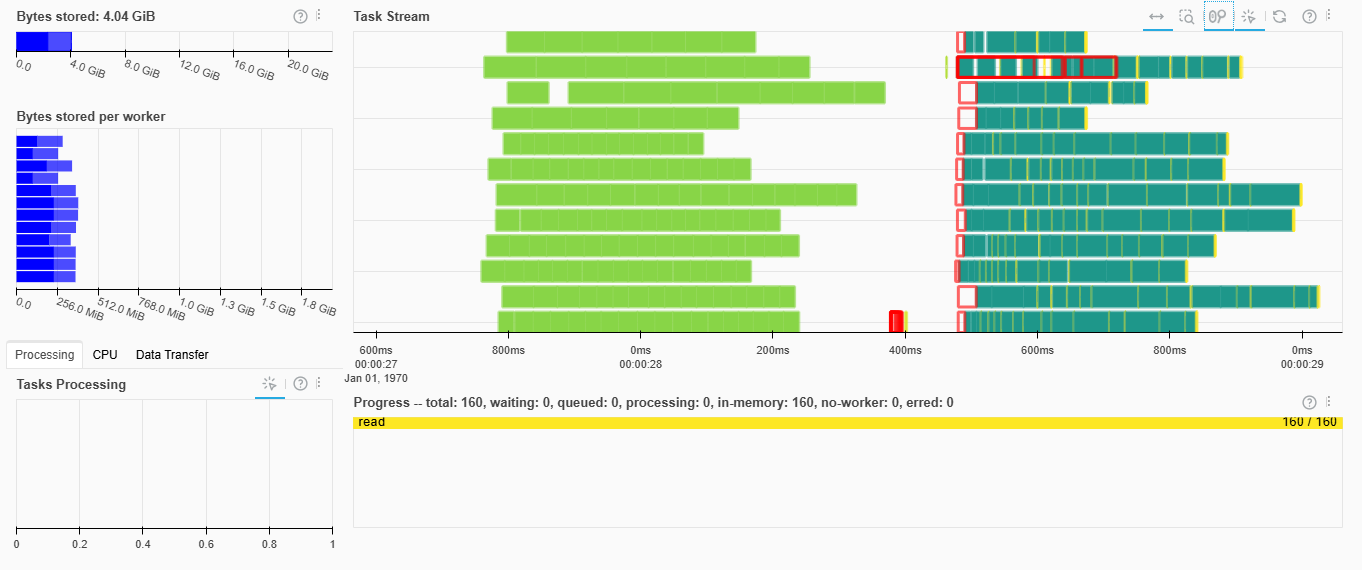

### Indirect_parallel_delayed function R dask vector scheme
N.B. To improve visualization the plot have been create for an environment having only three workers.

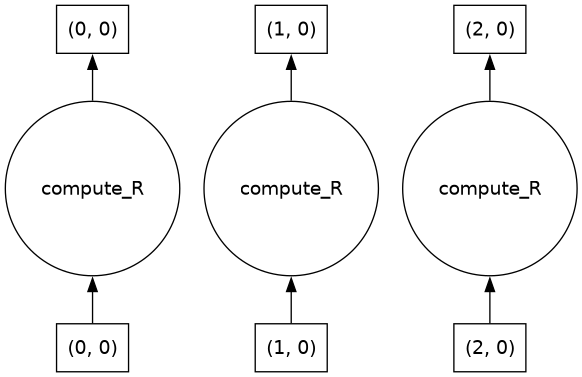


### Indirect_parallel_delayed function Q dask vector scheme
![alt text](fig/persisted_Q_horizzontal.svg)

In [ ]:
# not-delayed persisted version
t = measure_time(X_da, indirect_parallel_persisted, client)

print(t, "(s)")


1.3557639122009277 (s)


For the persisted version of the indirect TSQR, the Dask dashboard shows the following sequence:

- **Many green blocks**: These correspond to the computation of the local $(R_i)$ blocks on each worker (the map stage).

- **Many small yellow blocks**: After the green blocks finish, these represent persisting the local $(R_i)$ blocks in memory on each worker for later use.

- **Single small red block**: This is the first preparation, reduce stage, where the local $(R_i)$ blocks are gathered and the small global $(R_i)$ matrix is partially processed.

- **Many small cyan and yellow blocks**: These represent other preparation operations to compute $(R_i)$ lazily and persist it as a Dask array.

- **Second single small red block**: This corresponds to the actual computation of $(R_i)$, centralized on a single worker.

- **Many teal blocks**: As before, these correspond to the distributed multiplication $(Q_j = A_j R^{-1})$, i.e., computing the final $(Q)$ matrix. This is the broadcast/multiply stage, fully parallelized across workers.

---

This function exhibits a computation time similar to `indirect_parallel()`, but with the added advantage of **persisting the `R` matrix in memory**.  

As a result, it is **not necessary to recompute `R`** if the function is called again, since the matrix is already available. This makes the current approach the most efficient method tested so far.


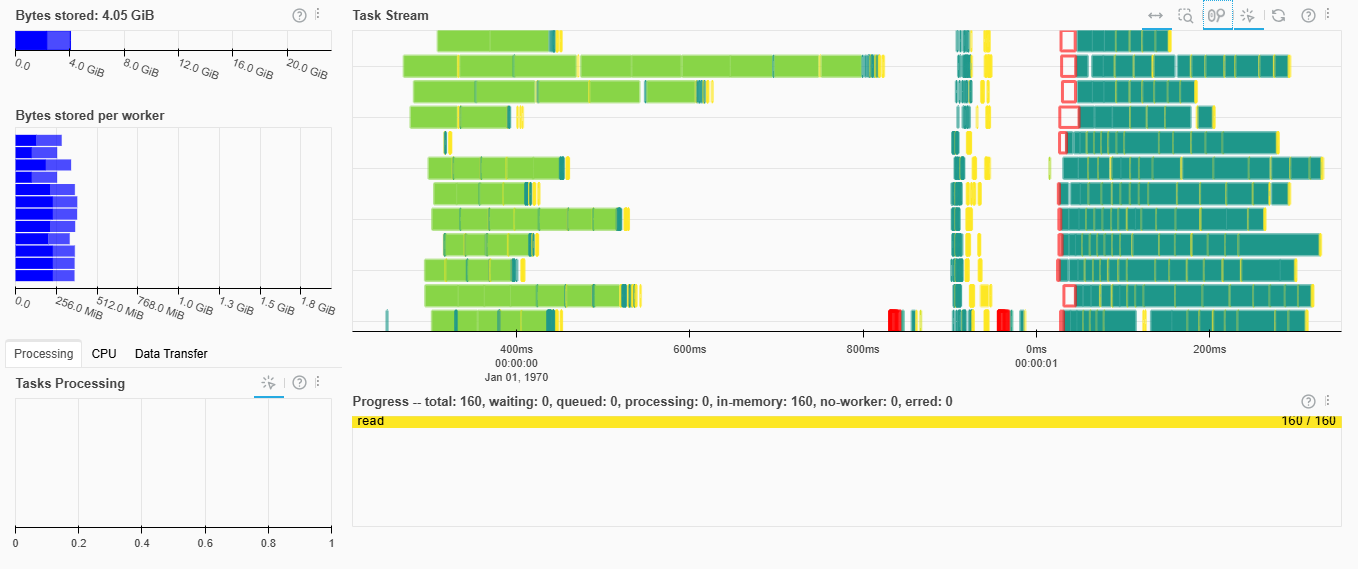

### Indirect_parallel_delayed function R dask vector scheme
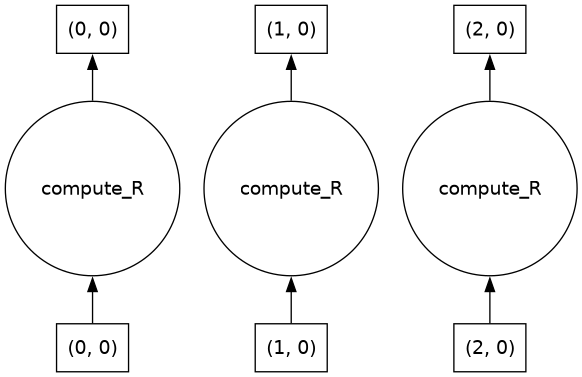
### Indirect_parallel_delayed function Q dask vector scheme
![alt text](fig/persisted_Q_horizzontal.svg)

In [ ]:
# fully-delayed version
t = measure_time(X_da, indirect_parallel_delayed, client)

print(t, "(s)")


7.080694675445557 (s)


For the delayed version of the indirect TSQR, the Dask dashboard shows the following sequence:

- **Many green blocks**: These correspond to the initial computation of the local $(R_i)$ blocks on each worker (the first map stage).

- **Single small red block**: This is the first reduce stage, where the local R_i blocks are vertically stacked into a single global matrix. This step centralizes the results onto a single worker to form the small global R matrix.

- **Many green blocks**: These correspond to further computation of $(R_i)$ blocks which is performed after the vstack operation such as the $(R_i^{-1})$ computation.

- **Many yellow blocks (reading / materializing)**:  
These appear because of the transition between Dask arrays and delayed objects. 
When `.to_delayed()` is caled on a Dask array,many delayed tasks are created, each wrapping a single chunk. These tasks still need to **pull the actual data from each worker** and the scheduler will have to coordinate all these transfers.  
Each yellow block represents a task **reading a chunk from a worker into memory**, and it includes network communication if the chunks are on remote workers. The large number of yellow blocks is proportional to the number of partitions and indicates a **performance bottleneck**.

This is the reason why this function spends so much time to run and will be **discarded** for the following benchmarking analysis.

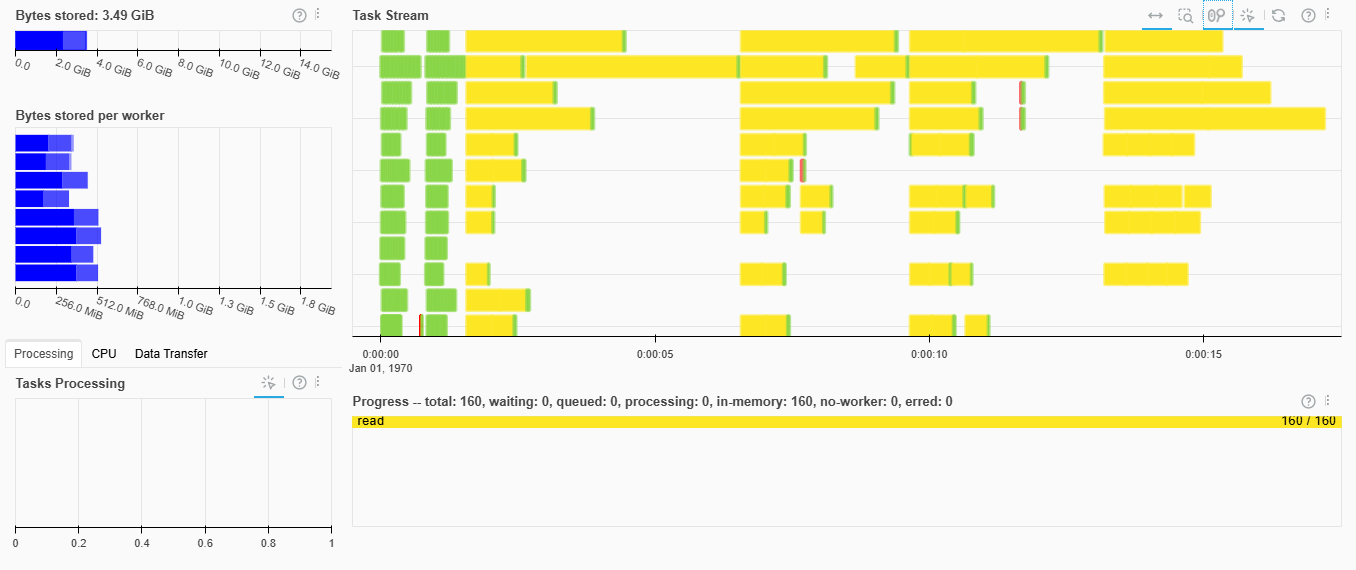

### Indirect_parallel_delayed function R dask vector scheme

<div>
  <img src="fig/delayed_R_horizzontal.svg.svg" width="700">
</div>

### Indirect_parallel_delayed function Q dask vector scheme

<div>
  <img src="fig/delayed_Q_horizzontal.svg.svg" width="700">
</div>

## Example: random matrix

In [11]:
N_WORKERS = 3
# Initialization of a distributed random matrix
m, n = int(1e7), 4
chunks = [m // N_WORKERS for _ in range(N_WORKERS-1)]
chunks.append(m - sum(chunks))
A = da.random.random((m, n), chunks=(chunks, n))

# Persist in memory to avoid recomputation
A = A.persist() 

print(f"Input matrix A: m = {A.shape[0]}, n = {A.shape[1]}")
print(f"The {len(A.chunks[0])} blocks are: {A.chunks[0]}")
print(f"Total size of A: {A.nbytes / 1e6} MB")
A


Input matrix A: m = 10000000, n = 4
The 3 blocks are: (3333333, 3333333, 3333334)
Total size of A: 320.0 MB


dask.array<random_sample, shape=(10000000, 4), dtype=float64, chunksize=(3333334, 4), chunktype=numpy.ndarray>

In [12]:
# QR decomposition


print("\n-- Computed (QR) --")
print( measure_time(X_da, indirect_parallel, client))
print("\n-- Persisted (QR) --")
print( measure_time(X_da, indirect_parallel_persisted, client))
print("\n-- Delayed (QR) --")
print( measure_time(X_da, indirect_parallel_delayed, client))



-- Computed (QR) --
1.9991798400878906

-- Persisted (QR) --
2.0793559551239014

-- Delayed (QR) --
17.698200702667236


In [25]:
client.close()
cluster.close()
